# Battery Cooling Simulation from Real Drive Cycle Data
Clean rebuild with proper structure and documentation

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import butter, filtfilt
import os
from datetime import datetime

# Configuration and File Paths
Set your paths here

In [34]:
DRIVE_CYCLE_FOLDER = "/home/keshav/Documents"
CORE_CSV_PATH = "/home/keshav/Documents/reserch_code/core.csv"
CHECKPOINT_DIR = "/home/keshav/Documents/reserch_code/checkpoints"
OUTPUT_PATH = "/home/keshav/Documents/reserch_code/simulated_battery_cooling.csv"

# Create necessary directories
os.makedirs("data", exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Simulation flags

In [35]:
FORCE_REBUILD_CORE = True  # Set to True to rebuild from raw data
ADIABATIC_MODE = True     # True = no cooling (for validation)

# Drive Cycle Data Processing Functions

In [36]:
def load_drive_cycle_files(folder_path):
    """Load and combine all .txt drive cycle files from a folder"""
    print("🔄 Building drive cycle dataset...")
    
    dfs = []
    txt_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".txt")])
    
    for file in txt_files:
        file_path = os.path.join(folder_path, file)
        
        # Try multiple encodings
        df = None
        for encoding in ["utf-16", "ISO-8859-1", "utf-8"]:
            try:
                df = pd.read_csv(
                    file_path,
                    sep="\t",
                    skiprows=1,
                    names=["Time", "Speed"],
                    encoding=encoding,
                    engine="python",
                )
                break
            except Exception as e:
                continue
                
        if df is None:
            print(f"⚠️ Skipping {file} (could not parse)")
            continue
            
        # Clean and add file identifier
        df = df.dropna()
        df["File"] = file
        dfs.append(df)
        print(f"   ✅ Loaded {file}: {len(df)} rows")
    
    if not dfs:
        raise RuntimeError("❌ No valid drive cycle files found!")
    
    return pd.concat(dfs, ignore_index=True)

In [37]:
def calculate_vehicle_dynamics(drive_df):
    """Calculate realistic vehicle power from speed data"""
    
    # Vehicle parameters
    MASS = 1800  # kg
    DRAG_COEFF = 0.28
    FRONTAL_AREA = 2.3  # m²
    ROLLING_RESISTANCE = 0.01
    AIR_DENSITY = 1.225  # kg/m³
    DRIVETRAIN_EFF = 0.9
    GRAVITY = 9.81
    
    # Convert speed to m/s and smooth it
    drive_df["Speed_mps"] = drive_df["Speed"] * 0.44704  # mph to m/s
    smooth_speed = drive_df["Speed_mps"].rolling(5, center=True).mean().fillna(method="bfill").fillna(method="ffill")
    
    # Calculate acceleration from smoothed speed
    drive_df["Acceleration"] = smooth_speed.diff().fillna(0)
    
    # Calculate forces
    F_aero = 0.5 * AIR_DENSITY * DRAG_COEFF * FRONTAL_AREA * smooth_speed**2
    F_roll = MASS * GRAVITY * (ROLLING_RESISTANCE + 0.0005 * smooth_speed)
    F_inertia = MASS * drive_df["Acceleration"]
    
    F_total = F_aero + F_roll + F_inertia
    
    # Calculate power (only positive - no regen for now)
    drive_df["Power_W"] = ((F_total * smooth_speed) / DRIVETRAIN_EFF).clip(lower=0)
    
    return drive_df

# Build or Load Drive Cycle Data

In [38]:
if not os.path.exists(CORE_CSV_PATH) or FORCE_REBUILD_CORE:
    # Build from raw files
    drive_df = load_drive_cycle_files(DRIVE_CYCLE_FOLDER)
    drive_df = calculate_vehicle_dynamics(drive_df)
    
    # Add cumulative time
    drive_df["CumulativeTime"] = np.arange(len(drive_df))
    
    # Save processed data
    drive_df.to_csv(CORE_CSV_PATH, index=False)
    print(f"✅ Saved core.csv with {len(drive_df)} rows")
    
else:
    # Load existing processed data
    drive_df = pd.read_csv(CORE_CSV_PATH)
    print(f"📄 Loaded existing core.csv with {len(drive_df)} rows")

# Extract simulation inputs
time_array = drive_df["CumulativeTime"].values
power_profile = drive_df["Power_W"].values
num_timesteps = len(time_array)

print(f"⏱️ Simulation setup: {num_timesteps} timesteps, ~{num_timesteps/60:.1f} minutes")

🔄 Building drive cycle dataset...
   ✅ Loaded reduced_speed_1C_180W_2mph.txt: 3600 rows
   ✅ Loaded reduced_speed_2C_360W_4mph.txt: 1800 rows
   ✅ Loaded reduced_speed_3C_540W_5mph.txt: 1200 rows
   ✅ Loaded reduced_speed_4C_720W_7mph.txt: 900 rows
✅ Saved core.csv with 7500 rows
⏱️ Simulation setup: 7500 timesteps, ~125.0 minutes


/tmp/ipykernel_19068/396449364.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  smooth_speed = drive_df["Speed_mps"].rolling(5, center=True).mean().fillna(method="bfill").fillna(method="ffill")


# Battery Pack Physical Parameters

In [39]:
# Pack configuration
NUM_ZONES = 4  # Number of thermal zones in the pack
INITIAL_TEMP = 25.0  # Starting temperature (°C)
AMBIENT_TEMP = 20.0  # Ambient/coolant temperature (°C)
PACK_VOLTAGE = 400.0  # Pack voltage (V)
PACK_CAPACITY = 80.0  # Pack capacity (Ah)

# Per-zone variation (realistic manufacturing tolerances)
np.random.seed(42)  # For reproducible results

# Internal resistance per zone (higher resistance = more heat)
base_resistance = 0.015  # Base resistance in ohms
resistance_variation = np.random.normal(1.0, 0.05, NUM_ZONES)
r_internal = base_resistance * resistance_variation
r_internal = np.clip(r_internal, 0.01, 0.03)

# Heat capacity per zone (thermal mass) - FIXED TO REALISTIC VALUES
base_heat_capacity = 500.0  # J/K per zone (much more realistic for battery cells)
capacity_variation = np.random.normal(1.0, 0.1, NUM_ZONES)  
heat_capacity = base_heat_capacity * capacity_variation
heat_capacity = np.clip(heat_capacity, 400.0, 600.0)

print("🔋 Battery pack parameters:")
print(f"   Zones: {NUM_ZONES}")
print(f"   Internal resistance range: {r_internal.min():.4f} - {r_internal.max():.4f} Ω")
print(f"   Heat capacity range: {heat_capacity.min():.0f} - {heat_capacity.max():.0f} J/K")

🔋 Battery pack parameters:
   Zones: 4
   Internal resistance range: 0.0149 - 0.0161 Ω
   Heat capacity range: 488 - 579 J/K


# Cooling System Parameters

In [40]:
if not ADIABATIC_MODE:
    # Active cooling parameters
    MAX_PUMP_FLOW = 10.0  # L/min total pump capacity
    BASE_HEAT_TRANSFER_COEFF = 50.0  # W/(K*zone) base convection
    FLOW_ENHANCEMENT_FACTOR = 2.0  # How much flow improves heat transfer
    PUMP_MAX_POWER = 150.0  # Maximum pump power (W)
    
    # Thermal conductance between adjacent zones
    LATERAL_CONDUCTANCE = 5.0  # W/K between adjacent zones
    
else:
    # Adiabatic mode - no cooling
    MAX_PUMP_FLOW = 0.0
    BASE_HEAT_TRANSFER_COEFF = 0.0
    FLOW_ENHANCEMENT_FACTOR = 0.0
    PUMP_MAX_POWER = 0.0
    LATERAL_CONDUCTANCE = 5.0  # Still allow conduction between zones

print(f"🌊 Cooling system: {'DISABLED (Adiabatic)' if ADIABATIC_MODE else 'ACTIVE'}")
if not ADIABATIC_MODE:
    print(f"   Max pump flow: {MAX_PUMP_FLOW} L/min")
    print(f"   Base heat transfer: {BASE_HEAT_TRANSFER_COEFF} W/K per zone")

🌊 Cooling system: DISABLED (Adiabatic)


# PID Controller for Temperature Control

In [41]:
class PIDController:
    """Simple PID controller for temperature regulation"""
    
    def __init__(self, Kp=5.0, Ki=0.1, Kd=1.0, setpoint=30.0, output_limits=(0.0, 1.0)):
        self.Kp = Kp
        self.Ki = Ki  
        self.Kd = Kd
        self.setpoint = setpoint
        self.output_limits = output_limits
        
        # Internal state
        self.integral = 0.0
        self.prev_error = 0.0
        
    def reset(self):
        """Reset controller state"""
        self.integral = 0.0
        self.prev_error = 0.0
        
    def update(self, measurement, dt=1.0):
        """Calculate PID output"""
        error = self.setpoint - measurement
        
        # PID terms
        proportional = self.Kp * error
        self.integral += error * dt
        integral_term = self.Ki * self.integral
        derivative = self.Kd * (error - self.prev_error) / dt if dt > 0 else 0.0
        
        # Combined output
        output = proportional + integral_term + derivative
        output = np.clip(output, *self.output_limits)
        
        self.prev_error = error
        return output

# Create PID controllers for each zone
TEMP_SETPOINT = 30.0  # Target temperature (°C)
pid_controllers = [PIDController(setpoint=TEMP_SETPOINT) for _ in range(NUM_ZONES)]

# Thermal Dynamics ODE System

In [42]:
def battery_thermal_ode(t, state, power_profile, params):
    """
    ODE system for battery thermal dynamics
    
    State vector: [T1, T2, ..., Tn, F1, F2, ..., Fn]
    Where Ti = temperature of zone i, Fi = coolant flow to zone i
    """
    
    # Unpack state
    temperatures = state[:NUM_ZONES]
    flows = state[NUM_ZONES:]
    
    # Get current power (interpolate if needed)
    time_idx = min(int(t), len(power_profile) - 1)
    current_power = power_profile[time_idx]
    
    # Calculate current and heat generation
    current = current_power / PACK_VOLTAGE  # A
    
    # Distribute heat generation based on resistance
    total_resistance = np.sum(params['r_internal'])
    heat_generation = np.zeros(NUM_ZONES)
    
    for i in range(NUM_ZONES):
        # Joule heating: I²R for this zone
        zone_current_fraction = params['r_internal'][i] / total_resistance
        heat_generation[i] = (current**2) * params['r_internal'][i]
    
    # Initialize derivatives
    dT_dt = np.zeros(NUM_ZONES)
    dF_dt = np.zeros(NUM_ZONES)
    
    # Calculate temperature derivatives for each zone
    for i in range(NUM_ZONES):
        T_i = temperatures[i]
        
        # Heat sources/sinks
        heat_in = heat_generation[i]
        
        # Lateral conduction with neighbors
        lateral_heat = 0.0
        if i > 0:  # Left neighbor
            lateral_heat += LATERAL_CONDUCTANCE * (temperatures[i-1] - T_i)
        if i < NUM_ZONES - 1:  # Right neighbor
            lateral_heat += LATERAL_CONDUCTANCE * (temperatures[i+1] - T_i)
            
        # Cooling (convection to coolant)
        cooling_heat = 0.0
        if not ADIABATIC_MODE:
            # Heat transfer coefficient depends on flow
            flow_factor = 1.0 + FLOW_ENHANCEMENT_FACTOR * flows[i]
            h_eff = BASE_HEAT_TRANSFER_COEFF * flow_factor
            cooling_heat = h_eff * (T_i - AMBIENT_TEMP)
        
        # Net heat change
        net_heat = heat_in + lateral_heat - cooling_heat
        
        # Temperature rate of change
        dT_dt[i] = net_heat / params['heat_capacity'][i]
    
    # Flow dynamics (simple first-order response to PID commands)
    TAU_FLOW = 2.0  # Flow time constant (seconds)
    
    for i in range(NUM_ZONES):
        # Get PID command (0-1 normalized flow)
        if not ADIABATIC_MODE:
            pid_output = params['pid_controllers'][i].update(temperatures[i])
            target_flow = pid_output  # Normalized flow (0-1)
        else:
            target_flow = 0.0
            
        # First-order flow response
        dF_dt[i] = (target_flow - flows[i]) / TAU_FLOW
    
    return np.concatenate([dT_dt, dF_dt])

In [43]:
# Set up simulation parameters
simulation_params = {
    'r_internal': r_internal,
    'heat_capacity': heat_capacity,
    'pid_controllers': pid_controllers
}

# Run the Thermal Simulation

In [44]:
print("🚀 Running thermal simulation...")

# Initial conditions
initial_temperatures = np.full(NUM_ZONES, INITIAL_TEMP)
initial_flows = np.zeros(NUM_ZONES)  # Start with no flow
initial_state = np.concatenate([initial_temperatures, initial_flows])

# Time span
t_start = 0
t_end = num_timesteps - 1
t_eval = np.arange(t_start, t_end + 1)

# Solve ODE system
solution = solve_ivp(
    fun=lambda t, y: battery_thermal_ode(t, y, power_profile, simulation_params),
    t_span=[t_start, t_end],
    y0=initial_state,
    t_eval=t_eval,
    method='RK45',
    rtol=1e-6
)

if not solution.success:
    print("❌ Simulation failed!")
    print(solution.message)
else:
    print("✅ Simulation completed successfully!")

# Extract results
temperatures = solution.y[:NUM_ZONES, :].T  # Shape: (time, zones)
coolant_flows = solution.y[NUM_ZONES:, :].T  # Shape: (time, zones)

print(f"📊 Results shape: temperatures {temperatures.shape}, flows {coolant_flows.shape}")

🚀 Running thermal simulation...
✅ Simulation completed successfully!
📊 Results shape: temperatures (7500, 4), flows (7500, 4)


# Post-process Results and Calculate Pump Power

In [45]:
# Calculate pump power at each timestep
pump_power = np.zeros(num_timesteps)

for t in range(num_timesteps):
    if not ADIABATIC_MODE:
        # Total volumetric flow (normalized flows * max capacity)
        total_flow_normalized = np.sum(coolant_flows[t, :])
        total_flow_lpm = total_flow_normalized * MAX_PUMP_FLOW
        
        # Pump power scales with flow squared (typical centrifugal pump)
        flow_fraction = total_flow_lpm / MAX_PUMP_FLOW if MAX_PUMP_FLOW > 0 else 0
        pump_power[t] = PUMP_MAX_POWER * (flow_fraction ** 2)
    else:
        pump_power[t] = 0.0

# Calculate some summary statistics
max_temp = np.max(temperatures)
min_temp = np.min(temperatures)
final_temps = temperatures[-1, :]
temp_range = max_temp - min_temp

print(f"🌡️ Temperature summary:")
print(f"   Range: {min_temp:.1f}°C to {max_temp:.1f}°C")  
print(f"   Final temperatures: {final_temps}")
print(f"   Total pump energy: {np.sum(pump_power) * 1/3600:.2f} Wh")

🌡️ Temperature summary:
   Range: 25.0°C to 25.2°C
   Final temperatures: [25.21674089 25.21612725 25.21522957 25.21537342]
   Total pump energy: 0.00 Wh


# Visualization

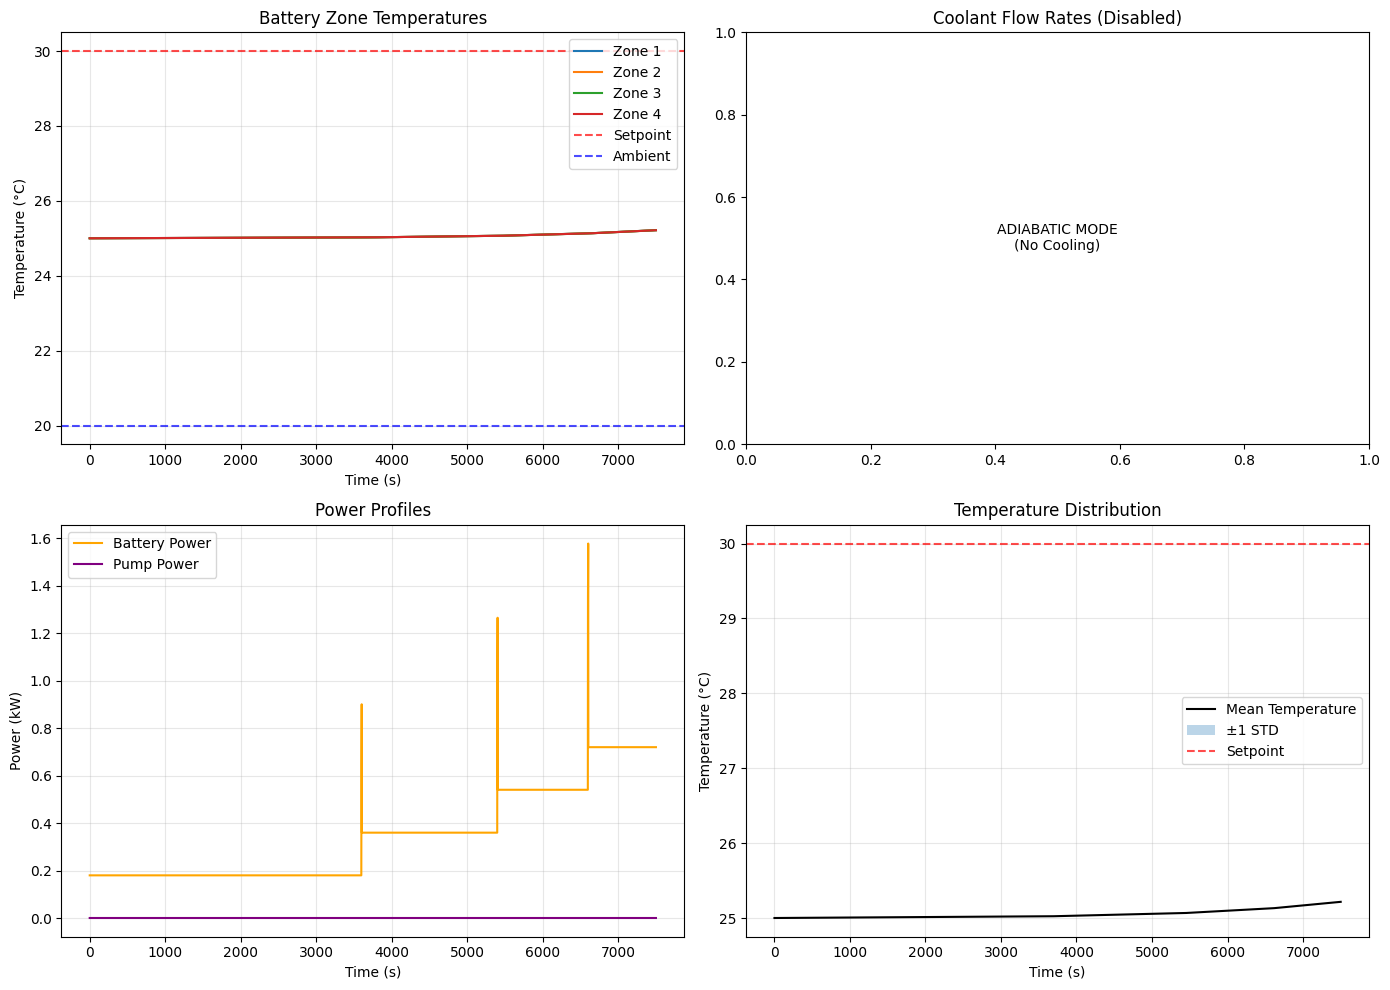

In [46]:
# Plot 1: Temperature profiles
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
for i in range(NUM_ZONES):
    plt.plot(time_array, temperatures[:, i], label=f'Zone {i+1}')
plt.axhline(y=TEMP_SETPOINT, color='r', linestyle='--', alpha=0.7, label='Setpoint')
plt.axhline(y=AMBIENT_TEMP, color='b', linestyle='--', alpha=0.7, label='Ambient')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.title('Battery Zone Temperatures')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Coolant flows
plt.subplot(2, 2, 2)
if not ADIABATIC_MODE:
    for i in range(NUM_ZONES):
        plt.plot(time_array, coolant_flows[:, i] * MAX_PUMP_FLOW, label=f'Zone {i+1}')
    plt.xlabel('Time (s)')
    plt.ylabel('Flow Rate (L/min)')
    plt.title('Coolant Flow Rates')
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'ADIABATIC MODE\n(No Cooling)', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Coolant Flow Rates (Disabled)')

# Plot 3: Power profile
plt.subplot(2, 2, 3)
plt.plot(time_array, power_profile / 1000, color='orange', label='Battery Power')
plt.plot(time_array, pump_power / 1000, color='purple', label='Pump Power')
plt.xlabel('Time (s)')
plt.ylabel('Power (kW)')
plt.title('Power Profiles')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Temperature distribution
plt.subplot(2, 2, 4)
temp_std = np.std(temperatures, axis=1)
temp_mean = np.mean(temperatures, axis=1)
plt.plot(time_array, temp_mean, 'k-', label='Mean Temperature')
plt.fill_between(time_array, temp_mean - temp_std, temp_mean + temp_std, 
                 alpha=0.3, label='±1 STD')
plt.axhline(y=TEMP_SETPOINT, color='r', linestyle='--', alpha=0.7, label='Setpoint')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save Results to CSV

In [47]:
results_df = pd.DataFrame()
results_df['Time'] = time_array
results_df['Power_W'] = power_profile
results_df['Pump_Power_W'] = pump_power

# Add temperature data
for i in range(NUM_ZONES):
    results_df[f'Zone_{i+1}_Temp_C'] = temperatures[:, i]
    
# Add flow data
for i in range(NUM_ZONES):
    results_df[f'Zone_{i+1}_Flow_LPM'] = coolant_flows[:, i] * MAX_PUMP_FLOW

# Add summary columns
results_df['Mean_Temp_C'] = np.mean(temperatures, axis=1)
results_df['Max_Temp_C'] = np.max(temperatures, axis=1) 
results_df['Temp_Range_C'] = np.max(temperatures, axis=1) - np.min(temperatures, axis=1)

# Save to file
results_df.to_csv(OUTPUT_PATH, index=False)
print(f"💾 Results saved to: {OUTPUT_PATH}")
print(f"📝 Saved {len(results_df)} timesteps with {len(results_df.columns)} variables")

💾 Results saved to: /home/keshav/Documents/reserch_code/simulated_battery_cooling.csv
📝 Saved 7500 timesteps with 14 variables


# Performance Summary

In [48]:
print("\n" + "="*50)
print("🎯 SIMULATION SUMMARY")
print("="*50)

print(f"Simulation duration: {num_timesteps} seconds ({num_timesteps/60:.1f} minutes)")
print(f"Battery pack zones: {NUM_ZONES}")
print(f"Operating mode: {'Adiabatic (no cooling)' if ADIABATIC_MODE else 'Active cooling'}")

print(f"\n🌡️ THERMAL PERFORMANCE:")
print(f"   Initial temperature: {INITIAL_TEMP:.1f}°C")
print(f"   Final mean temperature: {np.mean(final_temps):.1f}°C")
print(f"   Maximum temperature reached: {max_temp:.1f}°C")
print(f"   Temperature rise: {max_temp - INITIAL_TEMP:.1f}°C")
print(f"   Final temperature spread: {np.max(final_temps) - np.min(final_temps):.1f}°C")

if not ADIABATIC_MODE:
    total_pump_energy = np.sum(pump_power) / 3600  # Wh
    max_pump_power = np.max(pump_power)
    avg_pump_power = np.mean(pump_power)
    
    print(f"\n⚡ COOLING SYSTEM PERFORMANCE:")
    print(f"   Total pump energy: {total_pump_energy:.2f} Wh")
    print(f"   Peak pump power: {max_pump_power:.1f} W")
    print(f"   Average pump power: {avg_pump_power:.1f} W")
    print(f"   Cooling effectiveness: {((INITIAL_TEMP + 50) - max_temp)/(50):.1%}")

total_battery_energy = np.sum(power_profile) / 3600 / 1000  # kWh
peak_battery_power = np.max(power_profile) / 1000  # kW

print(f"\n🔋 ENERGY SUMMARY:")
print(f"   Total battery energy: {total_battery_energy:.2f} kWh") 
print(f"   Peak battery power: {peak_battery_power:.1f} kW")
if not ADIABATIC_MODE:
    print(f"   Cooling overhead: {(total_pump_energy/1000)/total_battery_energy:.2%}")

print("="*50)


🎯 SIMULATION SUMMARY
Simulation duration: 7500 seconds (125.0 minutes)
Battery pack zones: 4
Operating mode: Adiabatic (no cooling)

🌡️ THERMAL PERFORMANCE:
   Initial temperature: 25.0°C
   Final mean temperature: 25.2°C
   Maximum temperature reached: 25.2°C
   Temperature rise: 0.2°C
   Final temperature spread: 0.0°C

🔋 ENERGY SUMMARY:
   Total battery energy: 0.72 kWh
   Peak battery power: 1.6 kW


In [49]:
# DEBUG: Check the thermal calculations before running simulation
print("🔍 DEBUGGING THERMAL CALCULATIONS:")

# Test with a sample power value
test_power = 50000  # 50 kW - realistic high power
test_current = test_power / PACK_VOLTAGE
total_resistance = np.sum(r_internal)

print(f"Test power: {test_power/1000:.1f} kW")
print(f"Pack voltage: {PACK_VOLTAGE} V") 
print(f"Test current: {test_current:.2f} A")
print(f"Total pack resistance: {total_resistance:.6f} Ω")

# Check heat generation per zone
for i in range(NUM_ZONES):
    zone_heat = (test_current**2) * r_internal[i]  # Watts
    temp_rise_rate = zone_heat / heat_capacity[i]  # K/s
    temp_rise_per_minute = temp_rise_rate * 60  # K/min
    
    print(f"Zone {i+1}:")
    print(f"  Resistance: {r_internal[i]:.6f} Ω")
    print(f"  Heat capacity: {heat_capacity[i]:.0f} J/K") 
    print(f"  Heat generation: {zone_heat:.2f} W")
    print(f"  Temperature rise rate: {temp_rise_rate:.6f} K/s = {temp_rise_per_minute:.3f} K/min")

print(f"\nMax power in profile: {np.max(power_profile)/1000:.1f} kW")
print(f"This should give significant heating!")

🔍 DEBUGGING THERMAL CALCULATIONS:
Test power: 50.0 kW
Pack voltage: 400.0 V
Test current: 125.00 A
Total pack resistance: 0.061897 Ω
Zone 1:
  Resistance: 0.015373 Ω
  Heat capacity: 488 J/K
  Heat generation: 240.20 W
  Temperature rise rate: 0.491910 K/s = 29.515 K/min
Zone 2:
  Resistance: 0.014896 Ω
  Heat capacity: 488 J/K
  Heat generation: 232.75 W
  Temperature rise rate: 0.476670 K/s = 28.600 K/min
Zone 3:
  Resistance: 0.015486 Ω
  Heat capacity: 579 J/K
  Heat generation: 241.97 W
  Temperature rise rate: 0.417930 K/s = 25.076 K/min
Zone 4:
  Resistance: 0.016142 Ω
  Heat capacity: 538 J/K
  Heat generation: 252.22 W
  Temperature rise rate: 0.468492 K/s = 28.110 K/min

Max power in profile: 1.6 kW
This should give significant heating!
